In [8]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

In [9]:
print("Versions")
print(f"tensorflow : {tf.__version__}")
print(f"numpy : {np.__version__}")
print(f"opencv : {cv2.__version__}")

Versions
tensorflow : 2.13.0
numpy : 1.24.3
opencv : 4.8.1


# Data Set - Visualising the data

In [10]:
image_folder_path = os.path.join('Dog_Segmentation','Images')
mask_folder_path = os.path.join('Dog_Segmentation','Labels')

train_image_path = os.path.join(image_folder_path,'train')
train_mask_path = os.path.join(mask_folder_path,'train')
validation_image_path = os.path.join(image_folder_path,'validation')
validation_mask_path = os.path.join(mask_folder_path,'validation')
test_image_path = os.path.join(image_folder_path,'test')
test_mask_path = os.path.join(mask_folder_path,'test')

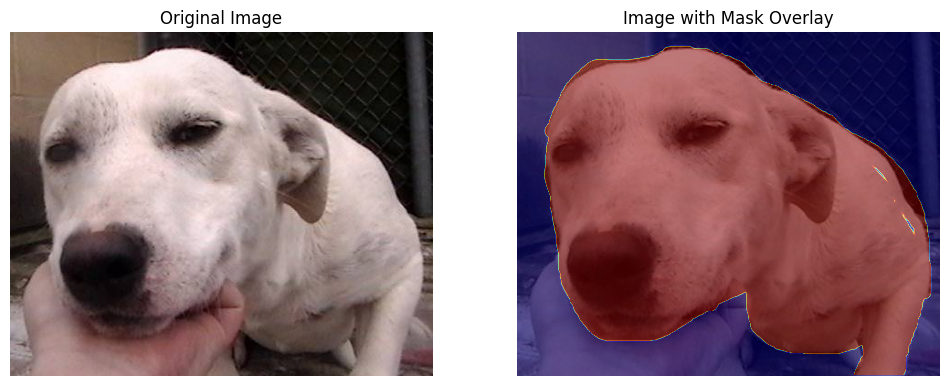

('Dog_Segmentation\\Images\\train\\dog.8874.jpg',
 'Dog_Segmentation\\Labels\\train\\annotated_dog.8874.jpg')

In [11]:
def view_random_image_and_mask(image_folder_path, mask_folder_path, subpath='train'):
    # List all files in the image sub-directory
    image_files = [file for file in os.listdir(os.path.join(image_folder_path, subpath))]

    # Randomly select an image file
    random_image = random.choice(image_files)

    # Construct the paths for the image and its corresponding mask
    image_path = os.path.join(image_folder_path, subpath, random_image)
    mask_path = os.path.join(mask_folder_path, subpath, 'annotated_' + random_image)

    # Read the image and the mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Plot the image and the mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with some transparency
    plt.title('Image with Mask Overlay')
    plt.axis('off')

    plt.show()

    return image_path, mask_path


view_random_image_and_mask(image_folder_path, mask_folder_path, 'train') 

In [12]:
def view_random_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    return np.array(image)

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_and_masks(image_dir, mask_dir, img_size=(160, 160)):
    images = []
    masks = []
    for image_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, 'annotated_' + image_name)
        image = load_img(img_path, target_size=(img_size, img_size))
        mask = load_img(mask_path, target_size=(img_size, img_size), color_mode="grayscale")
        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

In [48]:
train_images, train_masks = load_images_and_masks(train_image_path,train_mask_path ,img_size = 160)
val_images, val_masks = load_images_and_masks(validation_image_path, validation_mask_path, img_size = 160)

# U-net Architecture model

In [17]:
from tensorflow.keras import layers, models

# Building the convolutional block
def ConvBlock(inputs, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)
    
    return act2

# Building the encoder
def encoder(inputs, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

# Building the decoder
def decoder(inputs, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out

def get_U_Net(image_size):
    inputs = layers.Input(image_size)
    
    # Construct the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = ConvBlock(encoder_4, 64*16)
    
    # Construct the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    outputs = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = models.Model(inputs, outputs)
    return model

In [18]:
input_shape = (160, 160, 3)
model = get_U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 160, 160, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 160, 160, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 160, 160, 64)         0         ['batch_normalization[0][0

In [51]:
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("dog_segmentation.h5", save_best_only=True)
]


In [52]:
History =  model.fit( train_images, 
                      train_masks,
                      epochs = 50,
                      batch_size = 32,
                      steps_per_epoch= int(len(train_images)/32), 
                      validation_steps=10, 
                      validation_data=(val_images,val_masks))

Epoch 1/50
4/4 [==============================] - 258s 59s/step - loss: 1.0176 - accuracy: 0.5150 - val_loss: 1.0940 - val_accuracy: 0.4419
Epoch 2/50
4/4 [==============================] - 175s 52s/step - loss: 0.7939 - accuracy: 0.6549
Epoch 3/50
4/4 [==============================] - 211s 46s/step - loss: 0.6006 - accuracy: 0.7702
Epoch 4/50
4/4 [==============================] - 197s 49s/step - loss: 0.5589 - accuracy: 0.7771
Epoch 5/50
4/4 [==============================] - 191s 40s/step - loss: 0.5361 - accuracy: 0.7780
Epoch 6/50
4/4 [==============================] - 196s 41s/step - loss: 0.5046 - accuracy: 0.7850
Epoch 7/50
4/4 [==============================] - 133s 39s/step - loss: 0.4665 - accuracy: 0.8001
Epoch 8/50
4/4 [==============================] - 168s 42s/step - loss: 0.4618 - accuracy: 0.7979
Epoch 9/50
4/4 [==============================] - 150s 36s/step - loss: 0.4351 - accuracy: 0.8092
Epoch 10/50
4/4 [==============================] - 159s 39s/step - loss: 0.4

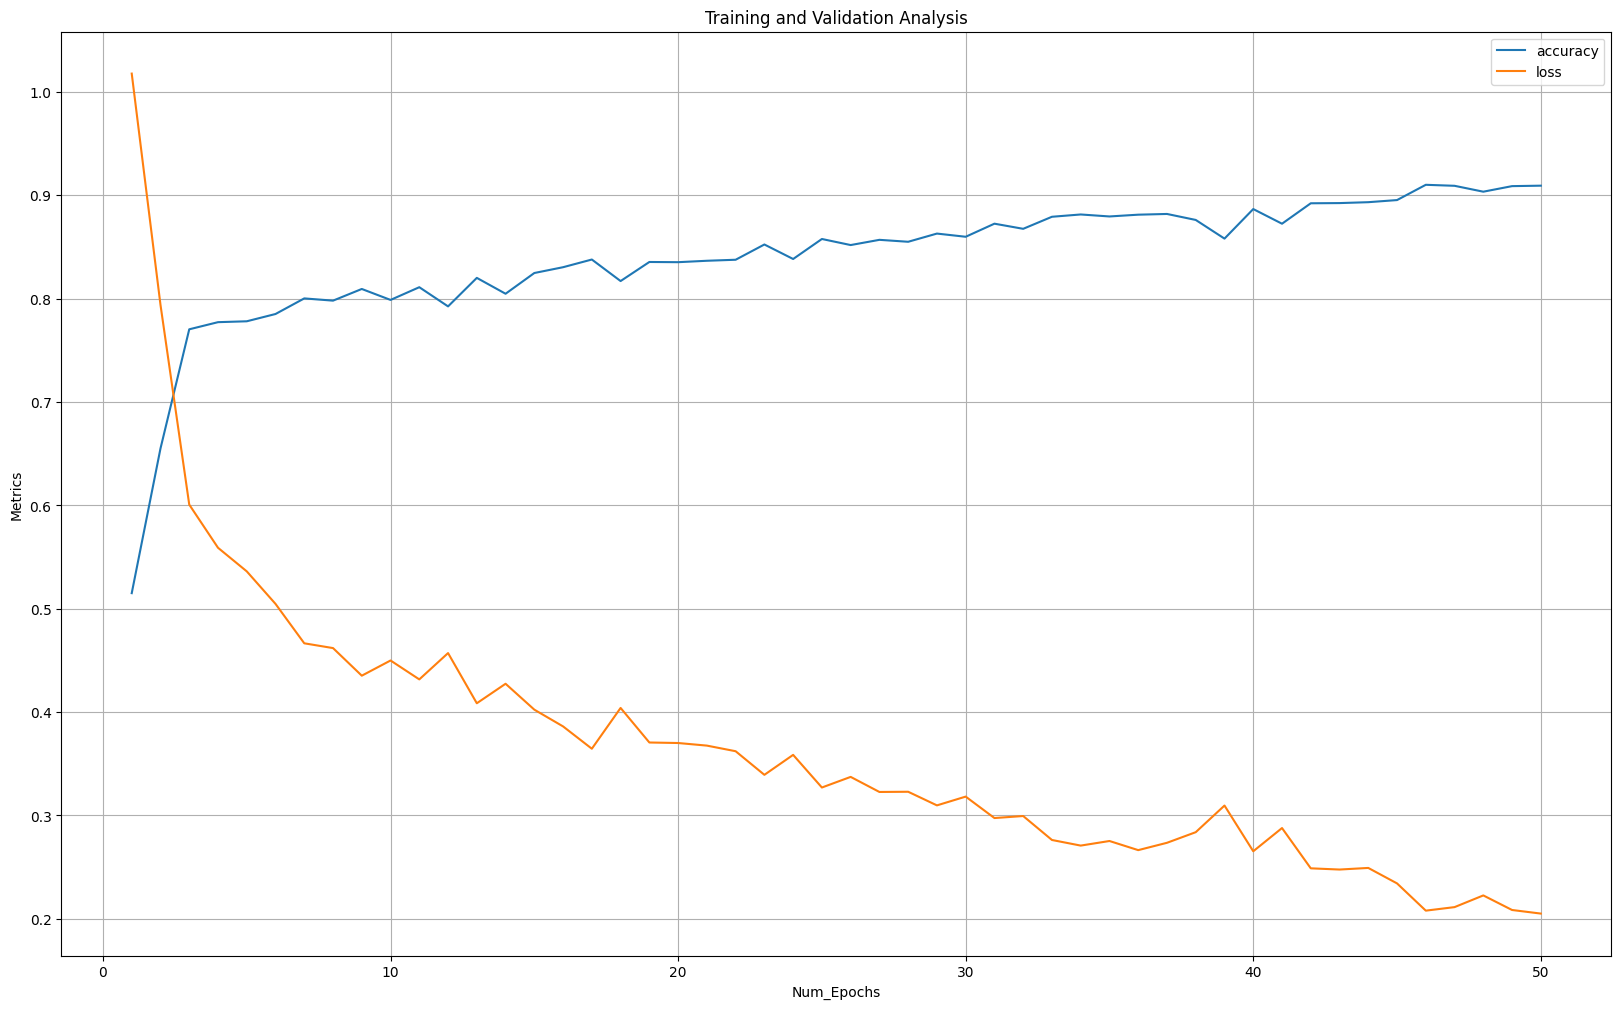

In [55]:
loss = History.history['loss']
accuracy = History.history['accuracy']
val_loss = History.history['val_loss']
val_accuracy = History.history['val_accuracy']
epoch_array = np.arange(1,51)

plt.figure(figsize=(20, 12))
plt.plot(epoch_array, accuracy, label='accuracy')
#plt.plot(epoch_array, val_accuracy, label='val_accuracy')
plt.plot(epoch_array, loss, label='loss')
#plt.plot(epoch_array, val_loss, label='val_loss')
plt.title("Training and Validation Analysis")
plt.xlabel("Num_Epochs")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()

In [19]:
test_images, test_masks = load_images_and_masks(test_image_path,test_mask_path ,img_size = 160)

In [20]:
predictions = model.predict(test_images)
predictions

1/1 [==============================] - 2s 2s/step


array([[[[0.50278443, 0.4985062 , 0.4973339 ],
         [0.49999163, 0.5030335 , 0.5003185 ],
         [0.49850386, 0.50416625, 0.4980884 ],
         ...,
         [0.49671915, 0.5044623 , 0.49720567],
         [0.49637735, 0.5041936 , 0.49786323],
         [0.49829593, 0.5054755 , 0.49856195]],

        [[0.5037958 , 0.49763015, 0.49641407],
         [0.50263935, 0.49908575, 0.5009571 ],
         [0.5035704 , 0.5008466 , 0.49697757],
         ...,
         [0.49956656, 0.5046678 , 0.49669513],
         [0.49833578, 0.50404197, 0.49424338],
         [0.5005764 , 0.50717443, 0.49495235]],

        [[0.50270176, 0.498954  , 0.49797496],
         [0.50263894, 0.4986562 , 0.4987425 ],
         [0.50227207, 0.5024335 , 0.498065  ],
         ...,
         [0.4991997 , 0.50163144, 0.4962693 ],
         [0.4981644 , 0.50312656, 0.4950428 ],
         [0.5007564 , 0.5057212 , 0.49419641]],

        ...,

        [[0.5015387 , 0.50002116, 0.50033385],
         [0.50232404, 0.49999526, 0.50105876]

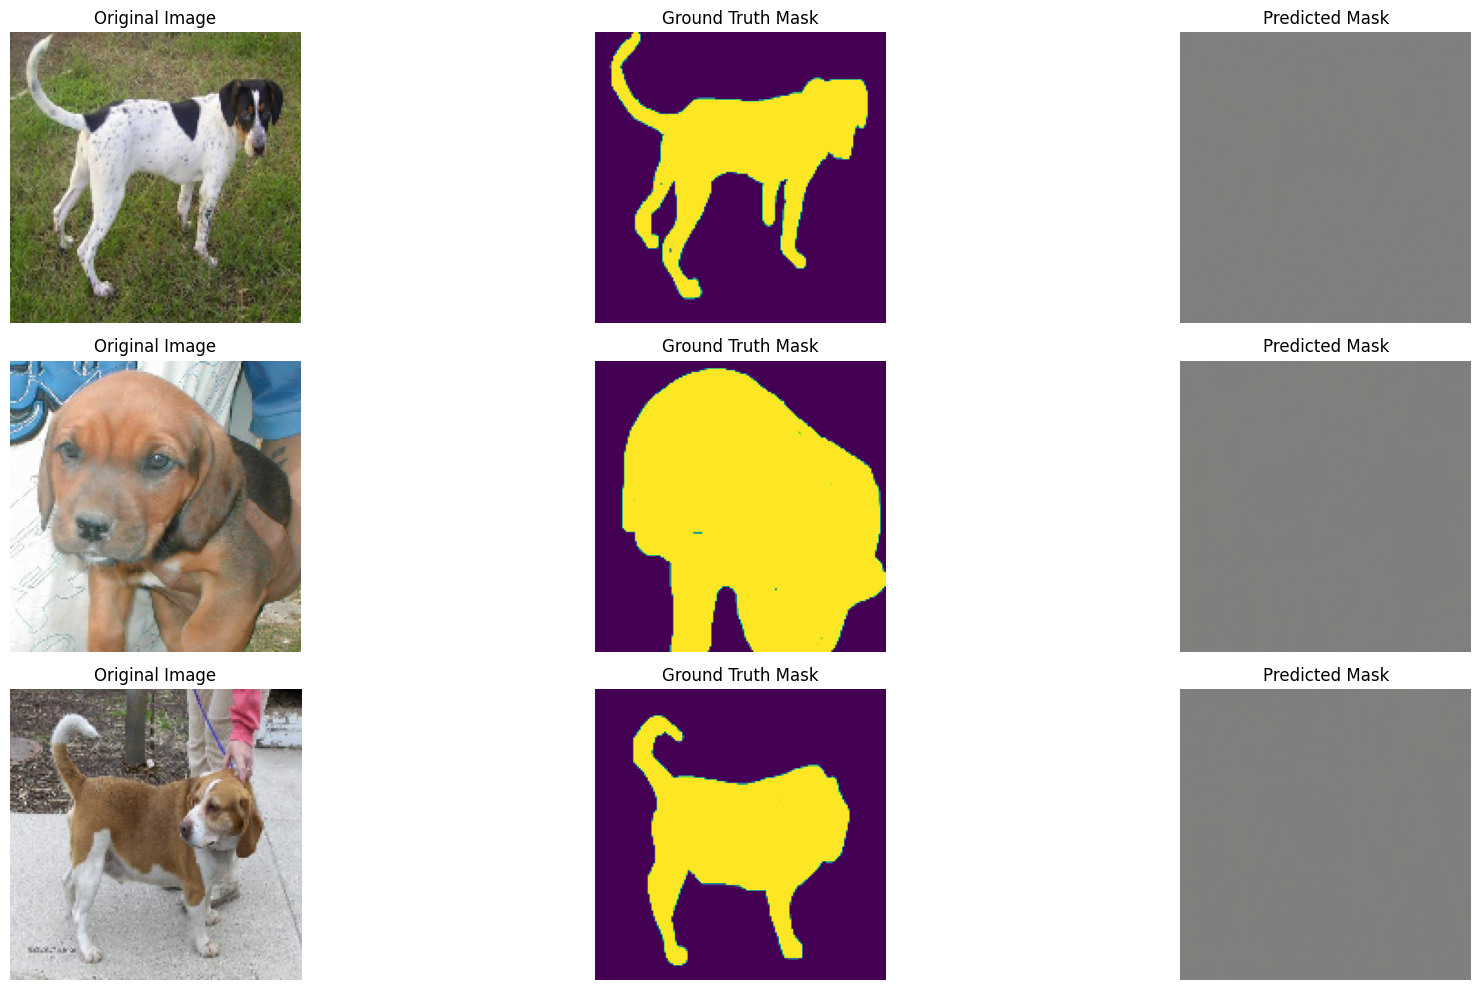

In [21]:
def display_predictions(test_images, predictions, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(test_images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(test_masks[i].squeeze())
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze())
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# Display the predictions
display_predictions(test_images, predictions, num_images=3)

# Save and Load Model Weights

In [60]:
model.save('models/Dog_Segmentation.keras')

In [22]:
model_loaded = tf.keras.models.load_model('models/Dog_Segmentation.keras')

1/1 [==============================] - 1s 564ms/step


(-0.5, 159.5, 159.5, -0.5)

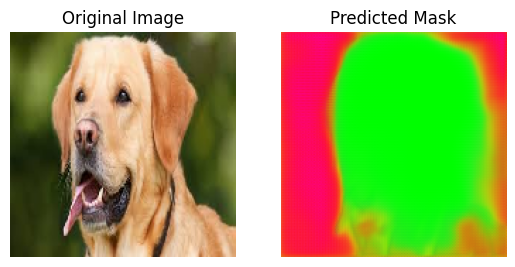

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_size = 160
#img_path = r'C:\Users\Dell\Downloads\test_dog1.jpeg'
img_path =os.path.join(r'C:\Users\Dell\Downloads','test_dog2.jpeg')
image = load_img(img_path, target_size=(img_size, img_size))
image = img_to_array(image) / 255.0

image = tf.expand_dims(image, axis=0) 
predictions = model_loaded.predict(image)

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Original Image')
plt.axis('off')

#  mask
plt.subplot(1,2,2)
plt.imshow(predictions.squeeze(),cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

In [24]:
import tensorflow as tf
model_loaded = tf.keras.models.load_model('models/dog_segmentation.keras')

predictions = model_loaded.predict(test_images)
predictions

1/1 [==============================] - 1s 841ms/step


array([[[[0.91574234, 0.39046305, 0.08575103],
         [0.9316428 , 0.2696758 , 0.14568305],
         [0.9422189 , 0.23217377, 0.21612304],
         ...,
         [0.96214134, 0.13153131, 0.24556392],
         [0.9560188 , 0.1718627 , 0.22696418],
         [0.94162625, 0.28386256, 0.16438185]],

        [[0.935742  , 0.26393256, 0.17608774],
         [0.95396996, 0.19154952, 0.19870985],
         [0.9701186 , 0.13021722, 0.21134043],
         ...,
         [0.9832617 , 0.06153491, 0.28117096],
         [0.98259366, 0.08066564, 0.2131621 ],
         [0.9574727 , 0.14946918, 0.14002986]],

        [[0.95005393, 0.23333749, 0.17458364],
         [0.96668774, 0.1435911 , 0.16769613],
         [0.9794905 , 0.11101298, 0.23472726],
         ...,
         [0.9910198 , 0.03315158, 0.3044914 ],
         [0.988125  , 0.05286642, 0.277514  ],
         [0.9686937 , 0.11476617, 0.19294435]],

        ...,

        [[0.9354341 , 0.28964764, 0.17438616],
         [0.9551605 , 0.21470538, 0.17181955]

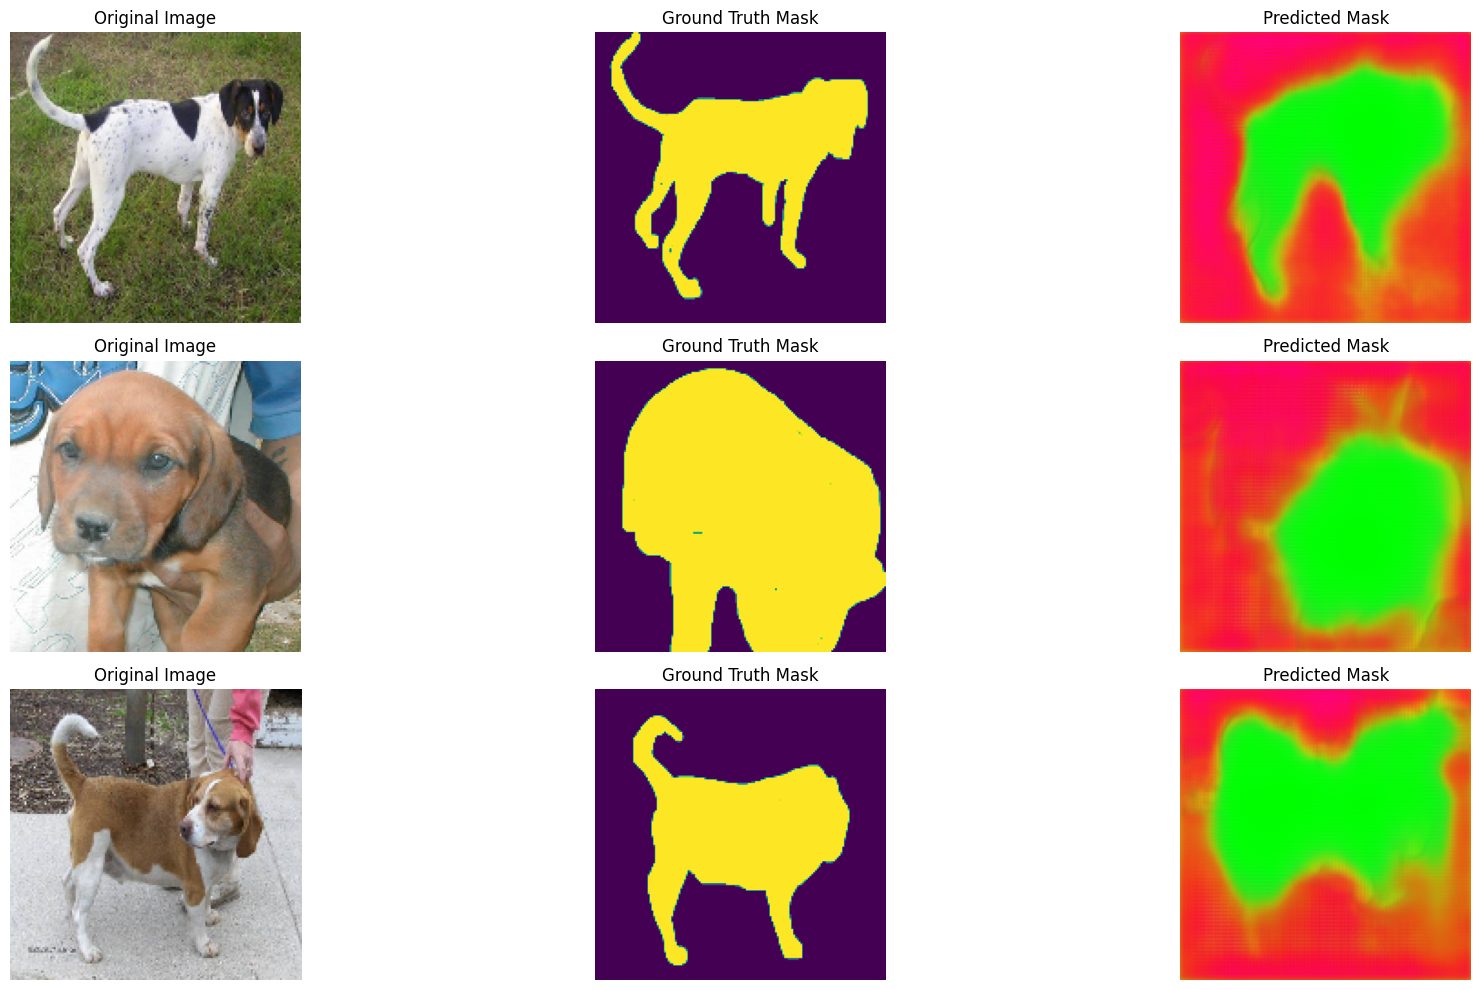

In [26]:
def display_predictions(test_images, predictions, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(test_images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(test_masks[i].squeeze())
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze())
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# Display the predictions
display_predictions(test_images, predictions, num_images=3)